In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
final_fig_path = "../../Figures/"
from time import time
from fun_response_funs import *
from fitness_funs import *

We use the non-dimensionalized parameters

fitness_funs from fitness_funs.py are in terms of non-dimensionalized params

In [4]:
from fun_response_funs import *

def pop_model_one_grp_size(t, initialstate,x, params):
    P, N1, N2 = initialstate
    dPdT = dPdT_one_grp_size(P, N1, N2, x, **params)
    dN1dT = dN1dT_one_grp_size(P, N1, N2, x, **params)
    dN2dT = dN2dT_one_grp_size(P, N1, N2, x, **params)

    return [dPdT, dN1dT, dN2dT]
    
def dPdT_one_grp_size(P, N1, N2, x, β, ξ, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. All preditors in groups of the same size

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    x - the group size of predators
    params - dic of params: β, a, H1, H2, η1, η2, α1_of_1, α2_of_1, s1, s2, ξ
    '''
    F_of_x = ξ*P/x
    tildeY1_of_x = fun_response_non_dim(x,N1,N2,1,**params)
    tildeY2_of_x = fun_response_non_dim(x,N1,N2,1,**params)

    return F_of_x*(β*tildeY1_of_x + tildeY2_of_x) - P
    
def dN1dT_one_grp_size(P, N1, N2, x, η1, ξ, **params):
    tildeY1_of_x = fun_response_non_dim(x,N1,N2,1,**params)
    return η1*N1*(1-N1) - (ξ*P/x)*tildeY1_of_x


def dN2dT_one_grp_size(P, N1, N2, x, η2, ξ, **params):
    tildeY2_of_x = fun_response_non_dim(x,N1,N2,2,**params)
    return η2*N2*(1-N2) - (ξ*P/x)*tildeY2_of_x   

def fun_response_non_dim(x, N1, N2, index, a, H1, H2, α2_fun_type,**params):
    '''
    non-dimensionalized functional response to prey as a function of predator group size (x) and 
    (non-dimensionalized prey population sizes (N1, N2)
    
    @inputs:
    x - pred group size
    N1, N2 - non-dim big prey and small prey pop sizes, respec
    index - 1 (big prey) or 2 (small prey)
    a - attack rate ratio of big prey to small prey
    H1, H2 - non-dimensionalized handling times of big prey, small prey, respec
    params: a dictionary of other parameters, that at least must include 
                α1_of_1, α2_of_1, s1, s2

    @returns
    functional response for prey type <index> (a float)

    @examples
    >>fun_response_non_dim(x=1,N1=0.8,N2=0.8,index=1,a=1,H1=5,H2=5, 
                    **dict(α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2) )
    0.008000000000000002
    '''
    if α2_fun_type == 'constant':
        α2 = params['α2_of_1']
    elif α2_fun_type == 'sigmoid':
        α2 = fun_attack_rate(x,2,**params)

        
    α1 = fun_attack_rate(x,1,**params)
    if index == 1:
        numerator = a*α1*N1
    elif index == 2:
        numerator = α2*N2
    denominator = 1 + α1*H1*N1 + α2*H2*N2
    return numerator/denominator

In [13]:
params_reg = dict(β=3, a=1, H1=5, H2=5, η1=3, η2=5, α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, ξ=10, α2_fun_type = 'constant')

In [44]:
dPdT_one_grp_size(P=0.7,N1=0.8,N2 = 0.8,x=3,**params_reg.copy())

-0.08139534883720922

In [45]:
dN1dT_one_grp_size(P=0.7, N1=0.8, N2=0.8, x=3, **params_reg.copy())

0.11379844961240304

In [46]:
t=1; P=0.1; N1=1; N2=1; x=1
pop_model_one_grp_size(t, [P, N1, N2],x, params_reg.copy())

[-0.075, -0.008333333333333335, -0.15833333333333333]

In [59]:
out.y.shape

(3, 82)

Text(0, 0.5, 'Predators, P')

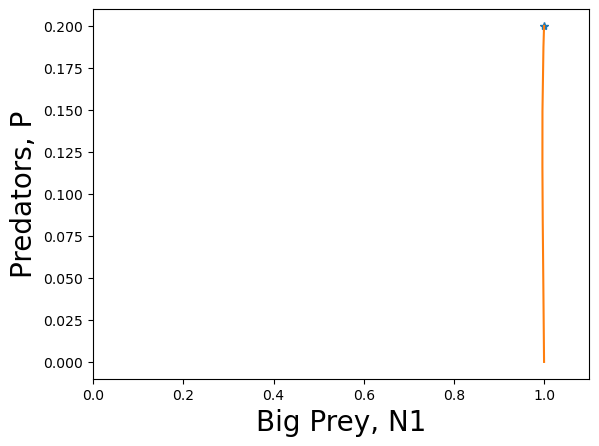

In [14]:
t_f = 100
initialstate = [0.2, 1, 1]
x=1
out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
plt.plot(initialstate[1], initialstate[0], marker = '*')

plt.plot(out.y[1,:],out.y[0,:])
plt.xlim([0,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)


Text(0, 0.5, 'Predators, P')

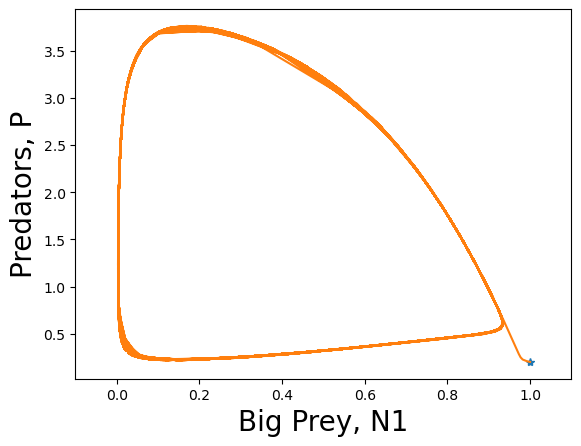

In [20]:
t_f = 1000
initialstate = [0.2, 1, 1]
x=2
out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
plt.plot(initialstate[1], initialstate[0], marker = '*')

plt.plot(out.y[1,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

Text(0, 0.5, 'Predators, P')

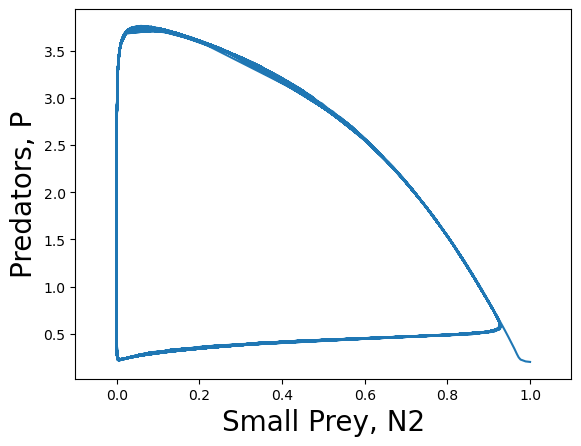

In [22]:
plt.plot(out.y[2,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Small Prey, N2', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

Text(0, 0.5, 'Predators, P')

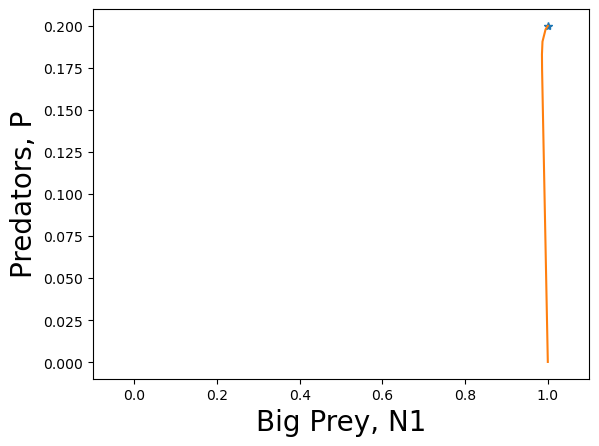

In [23]:
t_f = 100
initialstate = [0.2, 1, 1]
x=4
out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
plt.plot(initialstate[1], initialstate[0], marker = '*')
plt.plot(out.y[1,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

Text(0, 0.5, 'Predators, P')

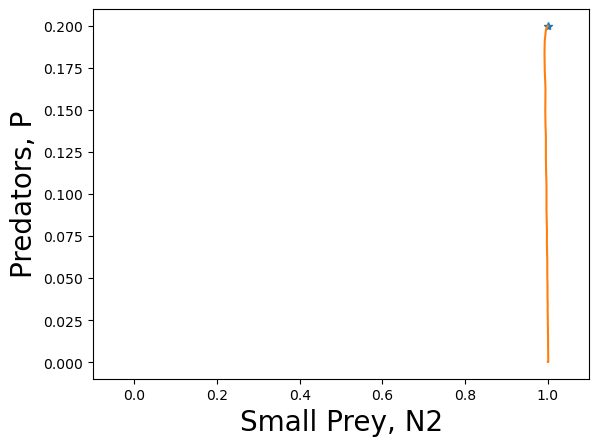

In [24]:
plt.plot(initialstate[1], initialstate[0], marker = '*')
plt.plot(out.y[2,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Small Prey, N2', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

In [4]:
1*0.05*0.8

0.04000000000000001

In [5]:
1+5*0.05*0.8 + 5*0.95*0.8

5.0

In [6]:
0.04/5

0.008